# Filtered Back Projection

We'll use the classes of PyTomography to implement filtered back projection in SPECT.

In [3]:
from pytomography.algorithms import FilteredBackProjection
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.metadata.SPECT import SPECTObjectMeta, SPECTProjMeta
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.utils import HammingFilter
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytomography.io.SPECT import dicom

## Creating The Object

Lets create a 3D rectangle in object space:

In [4]:
x = torch.linspace(-1,1,128)
y = torch.linspace(-1,1,128)
z = torch.linspace(-1,1,132)
xv, yv, zv = torch.meshgrid([x,y,z], indexing='ij')
object_truth = (xv>-0.2)*(xv<0.2)*(yv>-0.15)*(yv<0.15)*(zv>-0.1)*(zv<0.1)
object_truth = object_truth.to(torch.float).unsqueeze(dim=0) # add batch dimension
object_truth.shape

torch.Size([1, 128, 128, 132])

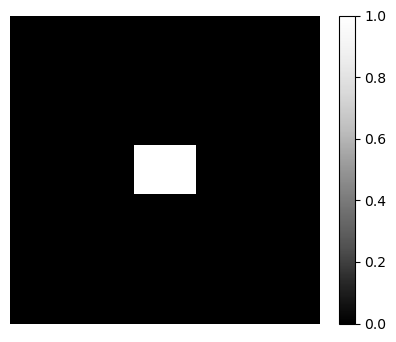

In [5]:
plt.figure(figsize=(5,4))
plt.pcolormesh(object_truth[0][:,:,64].T, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

We also need to create metadata that accompanies this image. In this case,  we'll assume the voxel sizes are 0.4 cm. For our projection space, we'll assume 120 projections are taken at angular spacing of 3 degrees. We'll assume an acquisition radius of 15cm

In [6]:
angles = np.arange(0,360.,3.)
radii = 15 * np.ones(len(angles))
object_meta = SPECTObjectMeta(dr=(0.4,0.4,0.4), shape=object_truth[0].shape)
proj_meta = SPECTProjMeta(projection_shape=object_truth[0,0].shape, angles=angles, radii=radii, dr=(0.4,0.4))

## Modeling the Imaging System

We'll model two different imaging systems here: an idealized imaging system, and a true SPECT imaging system. We'll show that filtered back projection reconstruction only performs well for the idealized system and not for the true SPECT system. The two systems are

1. An idealized imaging system characterized by the radon transform. In this case $H$ is simply a projection operator.
2. Representative of a true SPECT imaging system, with attenuation/PSF modeling. In this case, $H$ is more complicated.

We'll neglect scatter for now (equivalent to assuming perfect scatter correction). We'll show that while filtered back projection does a good job at reconstructing (1), its unable to account for attenuation/PSF modeling in (2)

### Case 1:

Our idealized imaging system is simply a SPECT imaging system without attenuation/PSF effects

In [7]:
system_matrix_radon = SPECTSystemMatrix(
    obj2obj_transforms=[],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta)

### Case 2:

We'll start by creating an attenuation map representative of water with photons at an energy of 140keV ($\mu \approx 0.15$ at this energy for water)

In [8]:
amap = (xv>-0.2)*(xv<0.2)*(yv>-0.15)*(yv<0.15)*(zv>-0.1)*(zv<0.1)
amap = amap.to(torch.float).unsqueeze(0) * 0.15
att_transform = SPECTAttenuationTransform(amap)

We'll assume imaging using Siemens medium energy collimators 

In [9]:
collimator_name = 'SY-ME'
energy_kev = 140
psf_meta = dicom.get_psfmeta_from_scanner_params(collimator_name, energy_kev)
psf_transform = SPECTPSFTransform(psf_meta)

Now we can create our system matrix that models the SPECT imaging system

In [10]:
system_matrix_SPECT = SPECTSystemMatrix(
    obj2obj_transforms=[att_transform, psf_transform],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta)

## Obtaining Imaging Data

We can now use the `forward` method of `system_matrix` to model $g=Hf$ (convert the object $f$ into an image $g$) for the case of (i) the radon transform and (ii) the SPECT system

In [11]:
proj_radon = system_matrix_radon.forward(object_truth)
proj_SPECT = system_matrix_SPECT.forward(object_truth)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

We can look at a projection at 60 degrees for example:

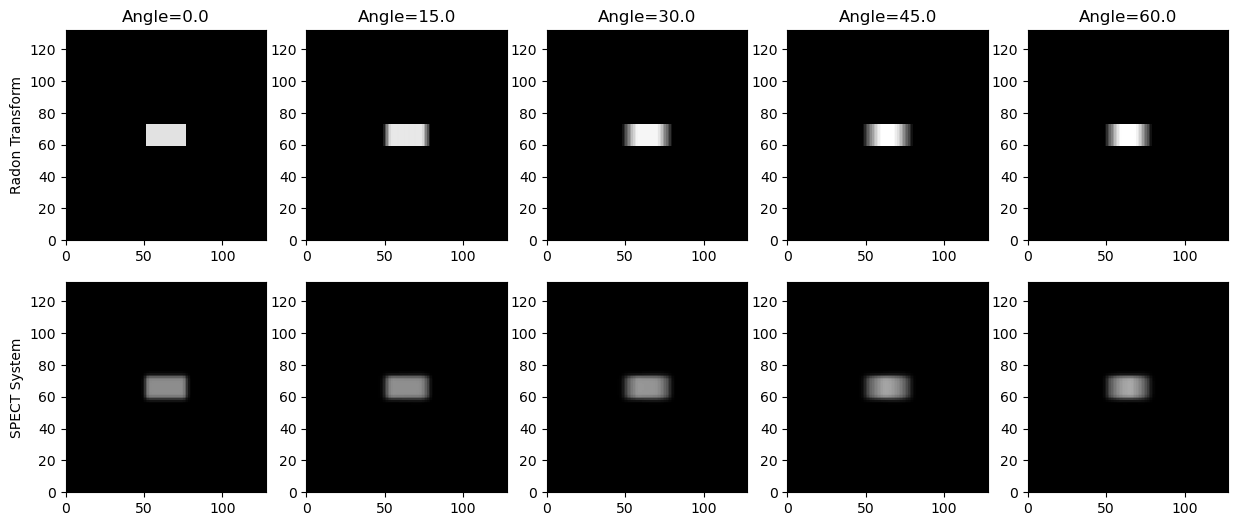

In [10]:
fig, axes = plt.subplots(2,5,figsize=(15,6))
for i, proj_idx in enumerate([0,5,10,15,20]):
    axes[0,i].pcolormesh(proj_radon.cpu()[0][proj_idx].T, cmap='Greys_r', vmax=25)
    axes[0,i].set_title(f'Angle={proj_meta.angles[proj_idx]}')
    axes[1,i].pcolormesh(proj_SPECT.cpu()[0][proj_idx].T, cmap='Greys_r', vmax=25)
axes[0,0].set_ylabel('Radon Transform')
axes[1,0].set_ylabel('SPECT System')
plt.show()

Note that the SPECT system yields an image with less counts (due to attenuation) and is blurrier (due to PSF modeling)

## Reconstruction

Filtered back projection is implemented through the `FilteredBackProjection` class

In [11]:
def filtered_back_projection(proj):
   fbp = FilteredBackProjection(proj, angles)
   object_prediction = fbp()
   return object_prediction

Now we can try reconstructing both the radon transform system and the idealized SPECT system

In [12]:
object_radon_fbp_prediction = filtered_back_projection(proj_radon)
object_SPECT_fbp_prediction = filtered_back_projection(proj_SPECT)

And we can plot the central axial slice of each reconstruction

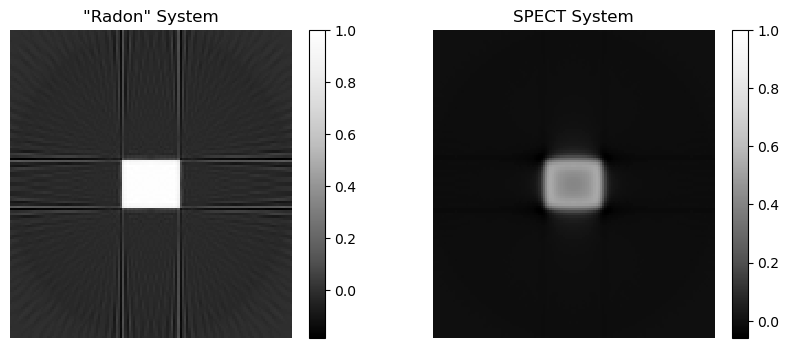

In [13]:
central_slice_radon = object_radon_fbp_prediction.cpu()[0][:,:,64].T
central_slice_SPECT = object_SPECT_fbp_prediction.cpu()[0][:,:,64].T

plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(central_slice_radon, cmap='Greys_r', vmax=1)
plt.axis('off')
plt.title('"Radon" System')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(central_slice_SPECT, cmap='Greys_r', vmax=1)
plt.axis('off')
plt.title('SPECT System')
plt.colorbar()
plt.show()

As can be seen, FBP works well so long as the imaging system is representative of a radon transform. In the case of SPECT imaging, this does not hold (attenuation correction has not been done, so the object is darker in the center).

## Additional Filtering

The high frequency artifacts present in both reconstructions can be removed by applying additional filters during filtered back projection. Here we use a Hamming filter with lower and upper cutoffs of 2% and 93% respectively.

In [14]:
def filtered_back_projection_hamming(proj):
    filter = HammingFilter(wl=0.02, wh=0.93)
    fbp = FilteredBackProjection(proj, angles, filter=filter)
    object_prediction = fbp()
    return object_prediction
 
object_radon_fbp_prediction = filtered_back_projection_hamming(proj_radon)
object_SPECT_fbp_prediction = filtered_back_projection_hamming(proj_SPECT)

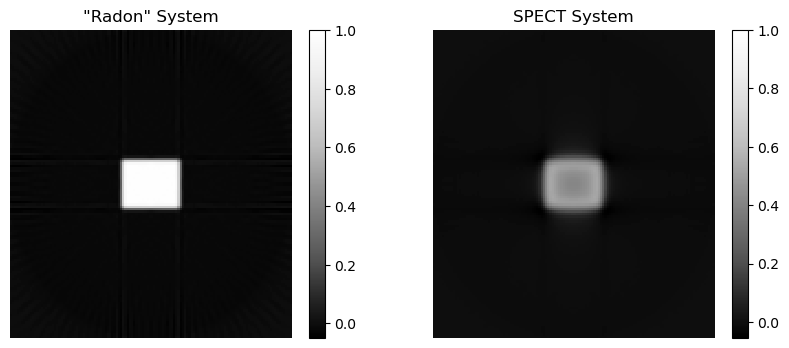

In [15]:
central_slice_radon = object_radon_fbp_prediction.cpu()[0][:,:,64].T
central_slice_SPECT = object_SPECT_fbp_prediction.cpu()[0][:,:,64].T

plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(central_slice_radon, cmap='Greys_r', vmax=1)
plt.axis('off')
plt.title('"Radon" System')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(central_slice_SPECT, cmap='Greys_r', vmax=1)
plt.axis('off')
plt.title('SPECT System')
plt.colorbar()
plt.show()